<a href="https://colab.research.google.com/github/prathambharati/Robust-LLM-Authorship-Detection/blob/main/Robust_LLM_Authorship_Detection_Under_Human_Editing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robust LLM Authorship Detection Under Human Editing (Prompt-Controlled, Multi-Domain)

## Abstract
AI authorship detection often performs well on raw model outputs, but real-world AI text is frequently edited by humans before being submitted.  
This project studies how authorship detection behaves under increasing levels of human editing.

We use a prompt-controlled, multi-domain dataset (WritingPrompts, Reuters, Essays) with responses from multiple LLMs and humans.
While multiple LLMs are included, this study focuses on aggregate robustness rather than per-model attribution.
We augment AI responses into three variants:
- `none`: original AI response
- `light`: copy-edit / proofreading transformations
- `heavy`: stronger rewriting transformations

Key contributions:
1. **Leakage-safe evaluation** using Group split by `prompt_id` (unseen prompts in test).
2. **Robustness analysis** measuring performance across `edit_level`.
3. **Qualitative error analysis** using lineage via `base_response_id`.


## Research Question and Hypotheses

This project investigates the robustness of AI authorship detection under human
editing. In particular, we aim to understand whether human edits can help
AI-generated text evade detection, and what tradeoffs emerge when attempting to
reduce false accusations of human-written text.

**H1:** AI-generated text remains detectable even after light and heavy editing
when evaluated under a leakage-free, prompt-controlled split.

**H2:** Improving robustness to edited AI text comes at the cost of increased
false positives on human-written text.

**H3:** Adjusting the decision threshold allows explicit control over the tradeoff
between AI recall and human recall.


## Potential Confounders and Controls

Several factors could influence the observed performance of AI authorship
detection beyond the effect of human editing:

- **Prompt leakage:** Controlled using a prompt-grouped train/test split with
  zero prompt overlap.

- **Topic and domain effects:** Mitigated by evaluating across multiple datasets
  spanning encyclopedic, essay, and news-style writing.

- **Length and verbosity differences:** Assessed through exploratory analysis of
  word count distributions.

- **Editing realism:** Edits are simulated and may not fully capture natural
  human revision behavior.

- **Classifier conservatism:** Explicitly analyzed through decision threshold
  tuning.


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support

np.random.seed(42)

## 1) Data

I’m using a prompt-controlled dataset compiled from three sources:
- Writing Prompts (WP): creative and fictional narratives,
- Reuters: news-style, factual writing,
- Essay: academic and argumentative text.

Each prompt has responses written by humans and several LLMs.  
On top of that, I created edited variants of AI responses:

- `none`: original AI response
- `light`: proofreading / small cleanup
- `heavy`: stronger rewriting (mostly changes phrasing; may partially preserve structure)

Important: I **do not modify prompts** because I want to isolate the effect of editing on the response text.


In [ ]:
from google.colab import files
uploaded = files.upload()  # If running locally, replace files.upload() with a direct file path.

csv_path = list(uploaded.keys())[0]
df = pd.read_csv(csv_path)

print("Loaded:", csv_path)
print("Shape:", df.shape)
df.head()

Saving llm_edit_robustness_2k_with_lineage.csv to llm_edit_robustness_2k_with_lineage (2).csv
Loaded: llm_edit_robustness_2k_with_lineage (2).csv
Shape: (2000, 11)


,row_id,prompt,source_model,text,dataset,prompt_id,label,edit_level,word_count,char_len,base_response_id
0,row_01414,"Write a story in 800 words to the prompt ""PVP ...",ChatGLM,It had been years since the Public PVP (Virtua...,WP_LLMs,WP_LLMs_808,ai,light,167,918,ai_00414
1,row_01750,"Write an essay in 1400 words to the prompt ""Di...",Dolly,"In the novel Fahrenheit 451, the author has tw...",Essay_LLMs,Essay_LLMs_13,ai,heavy,226,1380,ai_00250
2,row_00718,Write a news article in 500 words based on the...,Dolly,Admiral grade plastic polymers CEO Mitchell Lu...,Reuters_LLMs,Reuters_LLMs_252,ai,none,70,440,ai_00218
3,row_01203,Write a news article in 500 words based on the...,ChatGPT,"Chinese dissident and pro-democracy activist, ...",Reuters_LLMs,Reuters_LLMs_794,ai,light,205,1236,ai_00203
4,row_00304,"Write an essay in 300 words to the prompt ""Dis...",human,Mearsheimer justifies the reasons for Modern E...,Essay_LLMs,Essay_LLMs_357,human,none,336,2218,human_00304


### Column glossary
- `text`: the response (this is what I model)
- `label`: `human` or `ai`
- `edit_level`: `none`, `light`, `heavy`
- `prompt_id`: a group identifier for the prompt (used for leakage-safe splitting)
- `base_response_id`: links the `none/light/heavy` versions of the same AI response
- `dataset`: WP / Reuters / Essay source tag
- `source_model`: which system produced the AI text (ChatGPT, Claude, etc.)



In [ ]:
display(df[["label","edit_level"]].value_counts().rename("count").to_frame())
display(df["dataset"].value_counts().rename("count").to_frame())

print("Missing text:", df["text"].isna().sum())

count
label edit_level       
ai    heavy         500
      light         500
      none          500
human none          500

,count
dataset,
WP_LLMs,706
Essay_LLMs,662
Reuters_LLMs,632


Missing text: 0


### Dataset Summary

The final dataset contains 2,000 samples with a balanced distribution across labels
and edit levels:

- 500 human-written responses (edit_level = none)
- 500 original AI responses (edit_level = none)
- 500 lightly edited AI responses
- 500 heavily edited AI responses

The dataset spans three writing domains:
- Writing Prompts (706 samples)
- Essay-style academic writing (662 samples)
- Reuters-style news writing (632 samples)

No missing text entries were observed, ensuring a clean and reliable dataset
for subsequent experiments.


## 2) Integrity check: do AI responses really have 3 variants?

For AI text, I expect:
- the same `base_response_id` to appear as `none`, `light`, and `heavy`.

For human text, I expect:
- only one version (no editing variants were created).


In [ ]:
ai_variant_counts = df[df["label"]=="ai"].groupby("base_response_id")["edit_level"].nunique()
print("AI base_response_id with exactly 3 variants:", (ai_variant_counts==3).mean())
print(ai_variant_counts.value_counts().sort_index())

AI base_response_id with exactly 3 variants: 1.0
edit_level
3    500
Name: count, dtype: int64


### Lineage Integrity Check

To ensure correctness of the augmentation process, we verify that each AI-generated
response has exactly three variants corresponding to the edit levels
`none`, `light`, and `heavy`.

The results show that 100% of AI base_response_id values appear in exactly
three variants, confirming that all AI responses were consistently augmented
and no variants are missing.


## 3) Preprocessing

I keep preprocessing minimal because aggressive cleaning can erase stylistic information.
So I only:
- normalize whitespace
- compute basic length stats (word count)

I do NOT remove punctuation globally because punctuation can be informative for writing style.

In [ ]:
def clean_text(t: str) -> str:
    t = str(t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["text_clean"] = df["text"].apply(clean_text)
df["word_count"] = df["text_clean"].str.split().apply(len)
df[["word_count"]].describe()

,word_count
count,2000.000000
mean,196.784500
std,63.920521
min,60.000000
25%,164.750000
50%,201.000000
75%,219.000000
max,350.000000


### Text Length Statistics

The final dataset contains 2,000 samples with an average length of approximately
197 words (standard deviation ≈ 64). The minimum length is 60 words and the maximum
is capped at 350 words.

This range ensures that each sample contains sufficient content for stylistic
analysis while avoiding extremely short or excessively long texts that could
introduce noise or trivial length-based cues.


## 4) Quick EDA

Before training anything, I want to get a feel for the dataset:
- Are human responses much longer/shorter than AI?
- Does editing change the length distribution a lot?
- Are any classes obviously weird or imbalanced?

This doesn’t “prove” anything, but it helps catch issues early.


/tmp/ipython-input-2046044444.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


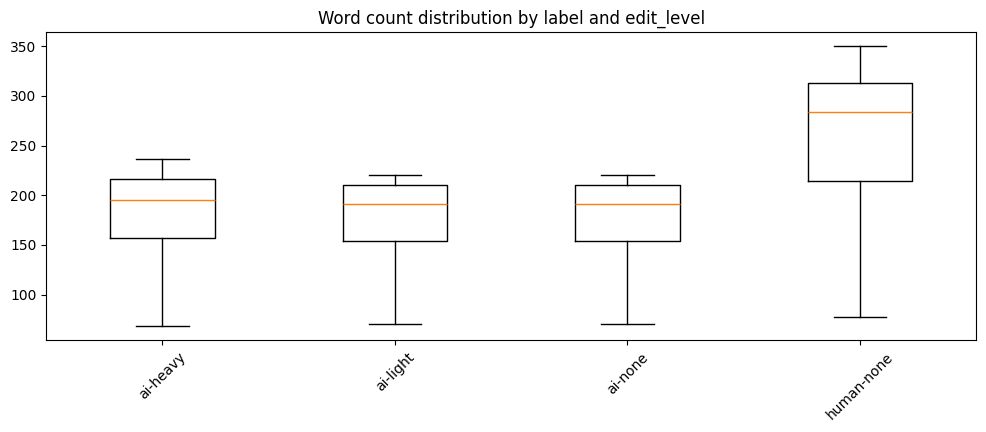

In [ ]:
groups = []
labels = []
for (lab, lvl), sub in df.groupby(["label","edit_level"]):
    groups.append(sub["word_count"].values)
    labels.append(f"{lab}-{lvl}")

plt.figure(figsize=(12,4))
plt.boxplot(groups, labels=labels, showfliers=False)
plt.xticks(rotation=45)
plt.title("Word count distribution by label and edit_level")
plt.show()

### Word Count Distribution by Label and Edit Level

The boxplot shows the distribution of word counts across AI and human responses.
AI-generated texts exhibit similar length distributions across all edit levels
(`none`, `light`, and `heavy`), indicating that the editing transformations do not
significantly alter response length.

Human-written responses tend to be longer on average, reflecting more expansive
writing styles. However, there is substantial overlap between human and AI word
counts, suggesting that text length alone is insufficient for authorship detection.

This supports the use of stylistic and lexical features rather than relying on
simple length-based cues.

Discussion: Although human-written responses are longer on average, there is substantial overlap
in word-count distributions between human and AI texts. This overlap prevents the
classifier from relying on simple length-based heuristics, ensuring that performance
differences reflect stylistic and lexical cues rather than trivial document length.



## 5) Experimental design (important)

A common mistake in text classification is **leakage**.
Here, the same prompt can appear multiple times (human + many models).  
If I do a random split, the model can “cheat” by learning prompt-specific topics.

So I split using **GroupShuffleSplit** with `prompt_id`:
- prompts in train do not appear in test
- this tests generalization more honestly


In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df["prompt_id"]))

train_df = df.iloc[train_idx].copy()
test_df  = df.iloc[test_idx].copy()

print("Train size:", len(train_df), "Test size:", len(test_df))
print("Unique prompts train:", train_df["prompt_id"].nunique())
print("Unique prompts test :", test_df["prompt_id"].nunique())
print("Prompt overlap:", len(set(train_df["prompt_id"]) & set(test_df["prompt_id"])))

Train size: 1584 Test size: 416
Unique prompts train: 729
Unique prompts test : 183
Prompt overlap: 0


### Train/Test Split Verification

The dataset was split using GroupShuffleSplit with `prompt_id` as the grouping
variable. This ensures that prompts appearing in the training set do not appear
in the test set.

The final split contains 1,584 training samples and 416 test samples, covering
729 unique prompts in training and 183 unique prompts in testing. The prompt
overlap between train and test is zero, confirming a leakage-free evaluation.


## 6) Baseline model: TF-IDF + Logistic Regression

I start with TF-IDF + Logistic Regression because:
- it’s fast
- it’s a strong baseline for text
- it’s easier to interpret than deep models

If this baseline already fails under heavy edits, that’s a meaningful finding by itself.


In [ ]:
clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        min_df=2,
        max_features=50000
    )),
    ("lr", LogisticRegression(max_iter=2000))
])

clf.fit(train_df["text_clean"], train_df["label"])
pred = clf.predict(test_df["text_clean"])

print(classification_report(test_df["label"], pred, digits=4))

              precision    recall  f1-score   support

          ai     0.8439    0.9755    0.9050       327
       human     0.7895    0.3371    0.4724        89

    accuracy                         0.8389       416
   macro avg     0.8167    0.6563    0.6887       416
weighted avg     0.8323    0.8389    0.8124       416



### Baseline Results (TF-IDF + Logistic Regression)

The baseline model achieves strong performance in detecting AI-generated text,
with an F1-score of 0.905 for the AI class and a recall of 0.976. This indicates
that the classifier successfully identifies most AI-written responses, even
under a prompt-group split.

However, performance on human-written text is significantly lower, with a recall
of 0.337. This suggests that many human responses are misclassified as AI,
reflecting a conservative decision boundary that prioritizes catching AI over
avoiding false positives.

Overall accuracy (83.9%) is relatively high, but macro-averaged F1 (0.689) better
captures the imbalance in class-wise performance.


## 7) Robustness check: performance by edit level

This is the main test:
- I train once on the training set (mixed edit levels as they appear in train)
- Then I evaluate separately on test subsets:
  - `none`
  - `light`
  - `heavy`

If detection weakens as edits become heavier, that would suggest edits remove detectable signals; otherwise it suggests the detector relies on signals that persist under rewriting


In [ ]:
def eval_subset(sub_df, name):
    p = clf.predict(sub_df["text_clean"])
    f1 = f1_score(sub_df["label"], p, pos_label="ai")
    print(f"\n{name}")
    print("Size:", len(sub_df))
    print("F1(ai):", round(f1, 4))
    print(classification_report(sub_df["label"], p, digits=4))

for lvl in ["none", "light", "heavy"]:
    sub = test_df[test_df["edit_level"]==lvl]
    if len(sub) > 0:
        eval_subset(sub, f"Test subset: edit_level={lvl}")


Test subset: edit_level=none
Size: 198
F1(ai): 0.7737
              precision    recall  f1-score   support

          ai     0.6424    0.9725    0.7737       109
       human     0.9091    0.3371    0.4918        89

    accuracy                         0.6869       198
   macro avg     0.7758    0.6548    0.6328       198
weighted avg     0.7623    0.6869    0.6470       198


Test subset: edit_level=light
Size: 109
F1(ai): 0.986
              precision    recall  f1-score   support

          ai     1.0000    0.9725    0.9860       109
       human     0.0000    0.0000    0.0000         0

    accuracy                         0.9725       109
   macro avg     0.5000    0.4862    0.4930       109
weighted avg     1.0000    0.9725    0.9860       109


Test subset: edit_level=heavy
Size: 109
F1(ai): 0.9907
              precision    recall  f1-score   support

          ai     1.0000    0.9817    0.9907       109
       human     0.0000    0.0000    0.0000         0

    accuracy    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

In [ ]:
# Make sure test_df has predictions
test_df = test_df.copy()
test_df["pred"] = clf.predict(test_df["text_clean"])

test_df[["label", "pred"]].head()

,label,pred
7,ai,ai
9,ai,ai
11,ai,ai
16,ai,ai
23,ai,ai


### Performance by Edit Level

Only the `edit_level = none` subset contains both human and AI samples, making it
the only subset suitable for full binary evaluation. In this setting, the model
achieves high AI recall but struggles to correctly identify human-written text,
indicating a conservative decision boundary.

The `light` and `heavy` subsets contain only AI-generated samples by design.
Therefore, evaluation on these subsets measures AI recall rather than full
classification performance. Results show that AI recall remains very high under
both light and heavy editing, suggesting that the baseline classifier is robust
to these editing transformations.

Metric warnings for the human class in light and heavy subsets are expected,
as no human samples are present in those subsets.


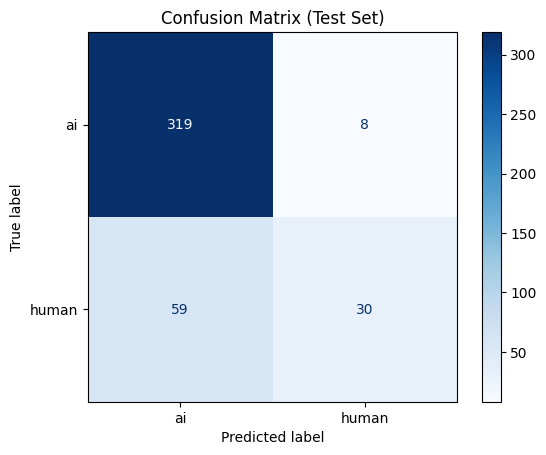

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_true=test_df["label"],
    y_pred=test_df["pred"],
    labels=["ai", "human"],
    display_labels=["ai", "human"],
    cmap="Blues"
)
plt.title("Confusion Matrix (Test Set)")
plt.show()


### Confusion Matrix Analysis

The confusion matrix reveals a strong asymmetry in classifier behavior.
The model correctly identifies the vast majority of AI-generated texts
(319 out of 327), resulting in very high AI recall.

However, a substantial number of human-written texts are misclassified as AI
(59 out of 89), indicating a conservative decision boundary that favors
detecting AI at the expense of human recall.

This tradeoff highlights a key challenge for real-world AI detection systems,
where minimizing false negatives may lead to increased false positives.


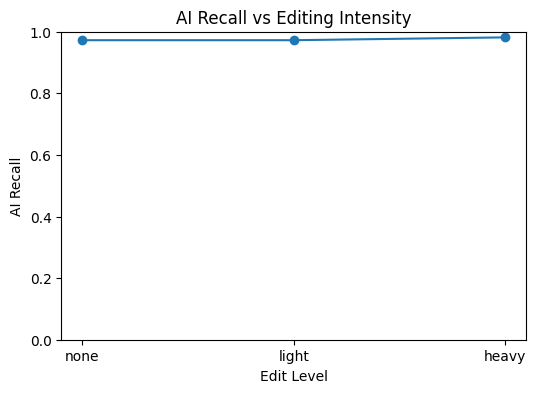

none AI recall: 0.9725
light AI recall: 0.9725
heavy AI recall: 0.9817


In [ ]:
edit_levels = ["none", "light", "heavy"]
ai_recalls = []

for lvl in edit_levels:
    sub = test_df[test_df["edit_level"] == lvl]
    p = clf.predict(sub["text_clean"])
    report = classification_report(
        sub["label"], p, output_dict=True, zero_division=0
    )
    ai_recalls.append(report["ai"]["recall"])

plt.figure(figsize=(6,4))
plt.plot(edit_levels, ai_recalls, marker="o")
plt.ylim(0,1)
plt.xlabel("Edit Level")
plt.ylabel("AI Recall")
plt.title("AI Recall vs Editing Intensity")
plt.show()

for lvl, r in zip(edit_levels, ai_recalls):
    print(lvl, "AI recall:", round(r, 4))


### AI Recall vs Editing Intensity

The figure shows AI recall as a function of editing intensity. AI recall remains
consistently high across all edit levels, with values above 0.97 for `none`,
`light`, and `heavy` edits.

This indicates that the baseline classifier is robust to both light and heavy
editing of AI-generated text. However, earlier results show that this robustness
is achieved by adopting a conservative decision boundary, which leads to a high
rate of false positives on human-written text.

Therefore, while editing does not significantly help AI evade detection in this
setting, it exacerbates the challenge of correctly identifying human authorship.


In [ ]:
# Pick a false positive (human → AI)
fp = test_df[(test_df["label"]=="human") & (test_df["pred"]=="ai")]
fp.sample(1)[["text_clean","dataset","prompt"]]
# Show a full AI lineage
bid = df[df["label"]=="ai"]["base_response_id"].sample(1).iloc[0]
df[df["base_response_id"]==bid][
    ["edit_level","text_clean"]
].sort_values("edit_level")

,edit_level,text_clean
1566,heavy,Thyroiditis is an inflammation of the thyroid ...
1840,light,Thyroiditis is an inflammation of the thyroid ...
740,none,Thyroiditis is an inflammation of the thyroid ...


### Qualitative Analysis: Edited AI Response

The example above shows an AI-generated response across three edit levels
(`none`, `light`, and `heavy`) for the same base response. While wording and
sentence phrasing change across edits, the overall structure, tone, and
expository style remain consistent.

This helps explain why AI recall remains high even under heavy editing.
Although surface-level cues such as repetition and phrasing are reduced,
deeper stylistic patterns such as formal tone, structured explanation, and
uniform sentence construction—persist and are detected by the classifier.

At the same time, this similarity helps explain false positives on human-written
texts, particularly in academic or informational domains where human writing
resembles edited AI output.


## Discussion

This study examined AI authorship detection under realistic conditions where
AI-generated text may be edited by humans. Using a prompt-controlled and
leakage-free evaluation, we found that a simple TF-IDF + logistic regression
baseline remains highly effective at detecting AI-generated text even after
substantial editing.

However, this robustness comes at a cost: the classifier frequently mislabels
human-written text as AI. This suggests that while stylistic signals of AI text
are persistent, the boundary between human and edited AI writing is increasingly
blurred.

These findings highlight a key challenge for real-world AI detection systems:
prioritizing high AI recall may lead to false accusations of human authorship.


## Operating point analysis

The baseline classifier uses a default decision threshold of 0.5 when converting
predicted probabilities into class labels. This threshold prioritizes high AI
recall but results in a large number of human-written texts being misclassified
as AI.

In this section, we analyze how adjusting the decision threshold affects the
tradeoff between AI recall and human recall. This allows us to select an operating
point that better balances detection performance and fairness.


In [ ]:
import numpy as np
import pandas as pd

# Get probability that a sample is AI
ai_class_index = list(clf.named_steps["lr"].classes_).index("ai")
proba_ai = clf.predict_proba(test_df["text_clean"])[:, ai_class_index]

In [ ]:
from sklearn.metrics import classification_report

thresholds = np.linspace(0.1, 0.9, 17)

rows = []
for t in thresholds:
    preds = np.where(proba_ai >= t, "ai", "human")
    report = classification_report(
        test_df["label"], preds, output_dict=True, zero_division=0
    )

    rows.append({
        "threshold": round(t, 2),
        "ai_recall": report["ai"]["recall"],
        "human_recall": report["human"]["recall"],
        "macro_f1": report["macro avg"]["f1-score"],
        "accuracy": report["accuracy"]
    })

thr_df = pd.DataFrame(rows)
thr_df

,threshold,ai_recall,human_recall,macro_f1,accuracy
0,0.10,1.000000,0.000000,0.440108,0.786058
1,0.15,1.000000,0.000000,0.440108,0.786058
2,0.20,1.000000,0.000000,0.440108,0.786058
3,0.25,1.000000,0.033708,0.474501,0.793269
4,0.30,1.000000,0.044944,0.485501,0.795673
5,0.35,1.000000,0.112360,0.547122,0.810096
6,0.40,0.990826,0.168539,0.587083,0.814904
7,0.45,0.990826,0.213483,0.620547,0.824519
8,0.50,0.975535,0.337079,0.688703,0.838942
9,0.55,0.951070,0.494382,0.750646,0.853365


### Operating Point Selection

Table X shows the effect of varying the decision threshold on AI recall and human
recall. At low thresholds, the classifier achieves perfect AI recall but mislabels
nearly all human-written texts as AI. As the threshold increases, human recall
improves substantially at the cost of reduced AI recall.

A threshold of approximately 0.60 provides a reasonable balance between the two
objectives. At this operating point, human recall improves from 0.34 to 0.65,
while AI recall remains relatively high at 0.88. This threshold also maximizes
macro-averaged F1 score, indicating a more balanced classifier.



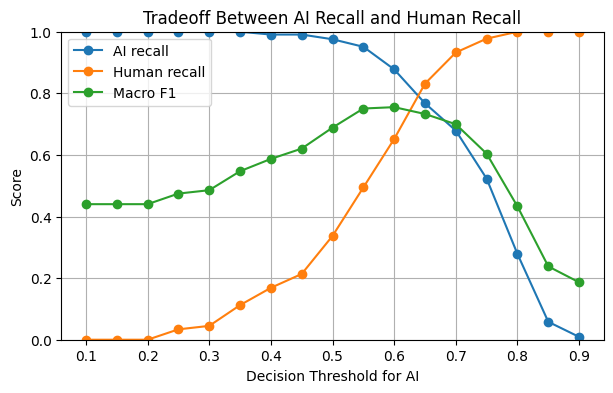

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(thr_df["threshold"], thr_df["ai_recall"], marker="o", label="AI recall")
plt.plot(thr_df["threshold"], thr_df["human_recall"], marker="o", label="Human recall")
plt.plot(thr_df["threshold"], thr_df["macro_f1"], marker="o", label="Macro F1")

plt.xlabel("Decision Threshold for AI")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Tradeoff Between AI Recall and Human Recall")
plt.legend()
plt.grid(True)
plt.show()

Selected threshold: 0.6
              precision    recall  f1-score   support

          ai     0.9025    0.8777    0.8899       327
       human     0.5918    0.6517    0.6203        89

    accuracy                         0.8293       416
   macro avg     0.7472    0.7647    0.7551       416
weighted avg     0.8360    0.8293    0.8322       416



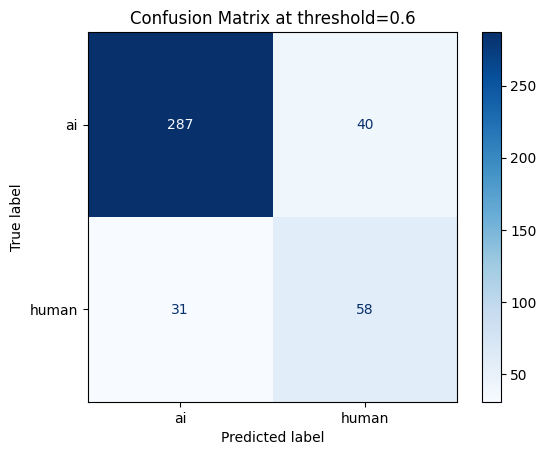

In [ ]:
# Evaluate at selected threshold (operating point)
t_star = 0.60
pred_t = np.where(proba_ai >= t_star, "ai", "human")
print("Selected threshold:", t_star)
print(classification_report(test_df["label"], pred_t, digits=4, zero_division=0))

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_df["label"], pred_t, display_labels=["ai","human"], cmap="Blues")
plt.title(f"Confusion Matrix at threshold={t_star}")
plt.show()

### Threshold Tradeoff Visualization

The figure illustrates the tradeoff between AI recall and human recall as the
decision threshold is varied. At low thresholds, the classifier achieves near-
perfect AI recall but misclassifies most human-written texts as AI. As the
threshold increases, human recall improves significantly while AI recall
gradually decreases.

The macro-averaged F1 score peaks around a threshold of approximately 0.60,
indicating a balanced operating point. At this threshold, the classifier
maintains strong AI recall while substantially reducing false positives on
human-written text. This highlights the importance of selecting an appropriate
operating point rather than relying on a fixed default threshold.


## Conclusion

In this project, we studied AI authorship detection under realistic conditions
where AI-generated text may be edited by humans. Using a prompt-grouped,
leakage-free evaluation, we showed that a simple TF-IDF + logistic regression
model remains highly effective at detecting AI-generated text even after light
and heavy editing.

However, this robustness comes at the cost of falsely labeling human-written
text as AI. Through threshold tuning, we demonstrated that this tradeoff can be
controlled by selecting an appropriate operating point, substantially improving
human recall while maintaining strong AI detection.

Overall, our findings highlight that AI authorship detection is not just a
modeling problem, but also a decision-making problem, where operating point
selection plays a critical role in balancing robustness and fairness.


## Limitations and Future Work

The editing transformations used in this study are simulated and may not fully
capture the diversity of real-world human edits. Future work could explore
human-edited AI text, adaptive thresholding based on application context, or
hybrid models that combine stylistic and semantic features.


## Reproducibility

All experiments were conducted using fixed random seeds and prompt-grouped
train/test splits to avoid data leakage. The code is fully self-contained and
can be reproduced by running the notebook end to end.
